In [1]:
# Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastf1 as ff1
import sys
sys.path.append("..")

from reuse.sessions import F1Session

In [2]:
# Create a directory for cache if it doesn't exist
if not os.path.exists('cache'):
    os.makedirs('cache')

In [3]:
# Enable fastf1 cache
ff1.Cache.enable_cache('cache')

In [4]:
races = [
    {'year': 2023, 'circuit': 1, 'session_type': 'R'},
    {'year': 2023, 'circuit': 2, 'session_type': 'R'},
    {'year': 2023, 'circuit': 3, 'session_type': 'R'},
    {'year': 2023, 'circuit': 4, 'session_type': 'R'},
    {'year': 2023, 'circuit': 5, 'session_type': 'R'},
    {'year': 2023, 'circuit': 6, 'session_type': 'R'},
    {'year': 2023, 'circuit': 7, 'session_type': 'R'},
    {'year': 2023, 'circuit': 8, 'session_type': 'R'}
]

In [5]:
f1_session = F1Session(races)

# Create list for all lap_times and session_results
lap_times = []
session_results = []

for session_data in f1_session:
    if session_data is not None:  # check if there's valid data
        lap_times.append(session_data['lap_times'])

# Concatenate all dataframes into one
lap_data = pd.concat(lap_times, ignore_index=True)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.2.8]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.2.8]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_da

In [52]:
lap_times_df = lap_data.copy()

In [53]:
# Create a dictionary of event names to event number
event_names = lap_times_df['EventName'].unique()
event_names_dict = {event_names[i]: i for i in range(len(event_names))}

In [54]:
# Map event names to event numbers and add to dataframe
lap_times_df['EventNumber'] = lap_times_df['EventName'].map(event_names_dict)

In [55]:
# Keep only the laptime, team, and event name columns
lap_times_df = lap_times_df[['LapTime', 'Team', 'EventName', 'EventNumber']]

# Filter to just Red Bull Racing and Aston Martin
lap_times_df = lap_times_df[lap_times_df['Team'].isin(
    ['Red Bull Racing', 'Aston Martin'])]

# Convert lap time to seconds
lap_times_df['LapTime'] = pd.to_timedelta(
    lap_times_df['LapTime']).dt.total_seconds()

# Group by team and event name, then calculate the mean lap time
lap_times_df = lap_times_df.groupby(
    ['Team', 'EventName', 'EventNumber']).mean().reset_index()

In [61]:
# Pivot the DataFrame
pivot_df = lap_times_df.pivot_table(
    index=['EventName', 'EventNumber'], columns='Team', values='LapTime')

# Calculate the difference and add it as a new column
pivot_df['LapTimeDiff'] = pivot_df['Aston Martin'] - \
    pivot_df['Red Bull Racing']

# Resetting the index
pivot_df.reset_index(inplace=True)

# Sorting the DataFrame based on EventNumber
pivot_df = pivot_df.sort_values('EventNumber')

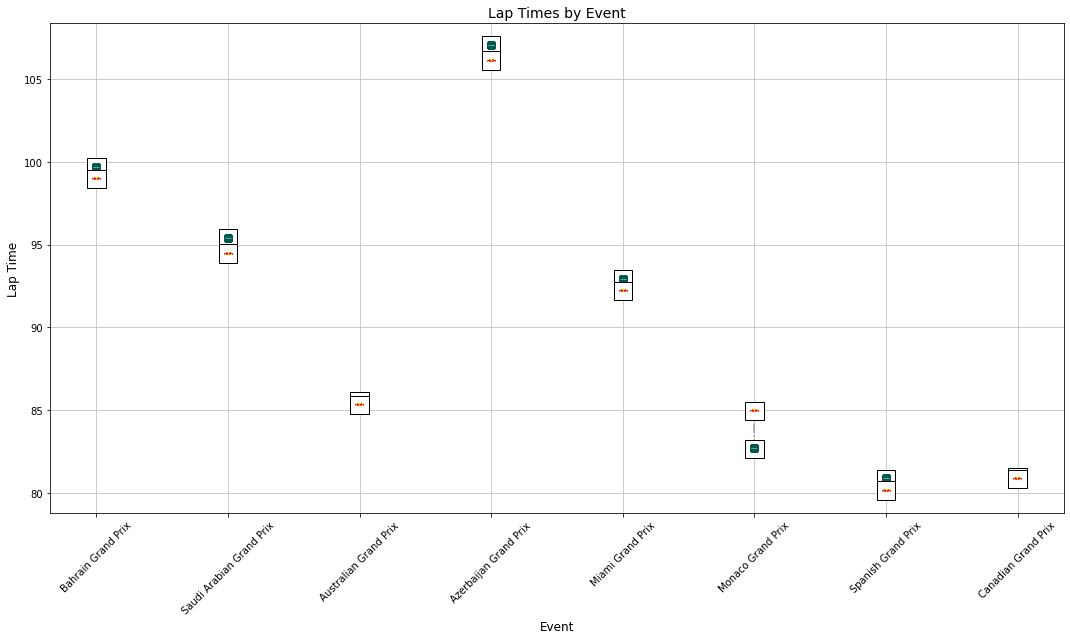

In [71]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Define the figure and the size
fig, ax = plt.subplots(figsize=(15, 9))

# Load the images
aston_img = mpimg.imread('images/logos/Aston Martin.jpg')
redbull_img = mpimg.imread('images/logos/Red Bull Racing.jpg')

# Generating x coordinates
x = np.arange(len(pivot_df))

# Create scatterplots and place the logos at each point
for i in range(len(x)):
    aston_logo = OffsetImage(aston_img, zoom=0.05)  # Adjust zoom as per requirement
    aston_ab = AnnotationBbox(aston_logo, (x[i], pivot_df['Aston Martin'].iloc[i]))
    ax.add_artist(aston_ab)
    
    redbull_logo = OffsetImage(redbull_img, zoom=0.05)  # Adjust zoom as per requirement
    redbull_ab = AnnotationBbox(redbull_logo, (x[i], pivot_df['Red Bull Racing'].iloc[i]))
    ax.add_artist(redbull_ab)

# Plotting LapTimeDiff with modified line style
for i in range(len(pivot_df)):
    ax.plot([x[i], x[i]], [pivot_df['Aston Martin'].iloc[i], pivot_df['Red Bull Racing'].iloc[i]], 
            color='grey', linestyle='-.', alpha=0.7)

# Setting x-axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(pivot_df['EventName'], rotation=45, fontsize=10)
ax.set_xlabel('Event', fontsize=12)
ax.set_ylabel('Lap Time', fontsize=12)
ax.set_title('Lap Times by Event', fontsize=14)

# Adding a grid for better readability
ax.grid(True, linestyle='-', color='0.75')

# Adjust layout to make room for the rotated x-axis labels
plt.tight_layout()

# Displaying the plot
plt.show()


In [73]:
# Save the plot
fig.savefig('images/laptimedeltalinechart.png', dpi=300, bbox_inches='tight')